In [2]:
import numpy as np
from copy import deepcopy
from scipy.constants import h, m_e, e, pi
import matplotlib.pyplot as plt
from pandas import DataFrame

In [3]:
# Crystal parameters
lattice = 'BCC' # bcc, fcc
a = 3.16e-10

# Apparatus parameters
V = 160e3
L = 1.6
beam = np.array([1,1,1])
wavelength = h / np.sqrt(2*m_e*e*V)

# Visualization
N = 2 # Extent of index
baseplane = np.array([0,0,1])
render_style = 'both' # helpful, pretty, both
pretty_resolution = 500
spot_size = 30

# Reconfirm values
print(f"Lattice constant\t\t{a/1e-10:g} Å")
print(f"Electron wavelength\t\t{wavelength/1e-10:g} Å")
print(f"Camera length\t\t{L} m")

Lattice constant		3.16 Å
Electron wavelength		0.0306606 Å
Camera length		1.6 m


In [4]:
# Set up dependent variables
d = lambda G: a/np.sqrt(np.dot(G,G))
R = lambda G: wavelength * L / d(G)
angle_between = lambda r1, r2: np.rad2deg(np.arccos(np.dot(r1,r2)/np.sqrt(np.dot(r1,r1)*np.dot(r2,r2))),dtype=float)
unit_vector = lambda r: r/np.sqrt(np.dot(r,r))

# Plane aligned with x-axis for angle calculations
if baseplane is None:
    if np.allclose(np.array([1,1,0]),beam):
        baseplane = np.array([0,0,1])
    elif np.allclose(np.array([1,1,1]),beam):
        baseplane = np.array([-1,1,1])

# Test if given plane can cause diffraction for given (real-space) lattice system
def meets_bcc(G):
    return np.sum(G)%2 == 0

def meets_fcc(G):
    return np.allclose(G%2,0) or np.allclose(G%2,1)

def smart_meets(G, lattice:str):
    if lattice.lower() == 'bcc':
        return meets_bcc(G)
    elif lattice.lower() == 'fcc':
        return meets_fcc(G)

In [5]:
# Find all the diffraction points
ii = np.arange(-N,N+1,1)
# Test all combinations of indices to see if diffraction occurs
allowed = []
for x in ii:
    for y in ii:
        for z in ii:
            plane = np.array([x,y,z])
            if x == 0 and y == 0 and z == 0:
                continue
            if np.dot(plane,beam) == 0 and smart_meets(plane, lattice):
                allowed.append(plane)
# Calculate R and angle
allowed_R = [wavelength*L/d(G)*100 for G in allowed]
allowed_d = [d(G)*1e10 for G in allowed]
df = DataFrame({'plane':allowed, 'd (Å)':allowed_d, 'R (cm)':allowed_R})

# Find all the TRUE angles using... linear algebra!
xv = baseplane
zv = beam
yv = np.cross(zv,xv)
xv, yv, zv = unit_vector(xv), unit_vector(yv), unit_vector(zv)
M = np.vstack([xv,yv,zv])
iM = np.linalg.inv(M)
lc = [np.matmul(r,iM)[0:2] for r in df['plane'].to_numpy()]
df['Angle (deg)'] = [np.sign(l[1])*90 if l[0] == 0 else np.rad2deg(np.arctan2(l[1],l[0])) for l in lc]

# Construct dataframe
# Translate from cylindrical to cartesian and add as columns
df['x (cm)'] = [R*np.cos(np.deg2rad(t)) for R,t in zip(df['R (cm)'].to_numpy(), df['Angle (deg)'].to_numpy())]
df['y (cm)'] = [R*np.sin(np.deg2rad(t)) for R,t in zip(df['R (cm)'].to_numpy(), df['Angle (deg)'].to_numpy())]

# Sort for better reading
df.sort_values(['R (cm)','Angle (deg)'], ascending=[True,True], ignore_index=True, inplace=True)

In [6]:
# Render functions
# Render as a labelled scatter plot
def helpful_render(ax, df):
    ax.scatter(df['x (cm)'], df['y (cm)'])
    ax.scatter(0,0)

    for i in range(len(df)):
        label = str(df.iloc[i]['plane']).replace('[','(').replace(']',')')
        x,y = df.iloc[i]['x (cm)']+0.2, df.iloc[i]['y (cm)']-0.1
        text = ax.annotate(label, (x, y),)
        text.set_fontsize(5)

    for i in ['top','bottom','left','right']:
        ax.spines[i].set_visible(False)

    corner = np.max([df['x (cm)'].to_numpy().max(), df['y (cm)'].to_numpy().max()])
    ax.set_ylim(np.floor(-corner),np.ceil(corner))
    ax.set_xlim(np.floor(-corner),np.ceil(corner))
    ax.set_aspect('equal')
    ax.set_xlabel('x (cm)')
    ax.set_ylabel('y (cm)')

# Function to generate a spot canvas
def spot(size, fall_off=4, clip=1.2):
    middle = int(size/2)
    canvas = np.zeros(size*size).reshape(size,size)
    for i in np.arange(0,size):
        for j in np.arange(0,size):
            x, y = i-middle, j-middle
            distance = np.sqrt(x*x+y*y)
            sx = np.min([distance/middle, np.pi/2])
            value = np.cos(sx)**fall_off
            canvas[x+middle,y+middle] = min([value*clip,1.0])
    return canvas

# Instructions for rendering a spot in the canvas
def render_spot(canvas, spot, center, extent_max, opacity=1.0):
    spot_res = spot.shape[0]
    res = canvas.shape[0]
    x,y = center[0]/extent_max, center[1]/extent_max
    x_in_pixels, y_in_pixels = res/2*(1+x), res/2*(1+y)
    x_ip_offset, y_ip_offset = int(x_in_pixels-spot_res/2), int(y_in_pixels-spot_res/2)
    for i in np.arange(0,spot_res):
        for j in np.arange(0,spot_res):
            try:
                canvas[y_ip_offset+j,x_ip_offset+i] += spot[i,j]*min([opacity,1])
            except IndexError:
                pass

# Render as a mock picture
def pretty_render(ax, df, res=500):
    small_spot = spot(spot_size)
    large_spot = spot(int(1.4*spot_size), clip=1.5)

    extent_max = np.ceil(np.max([df['x (cm)'].to_numpy().max(), df['y (cm)'].to_numpy().max()]))
    canvas = np.zeros(res*res).reshape(res,res)

    # Render all the spots
    R_min = df['R (cm)'].to_numpy().min()
    for x,y,R in zip(df['x (cm)'].to_numpy(), df['y (cm)'].to_numpy(), df['R (cm)'].to_numpy()):
        render_spot(canvas, small_spot, (x,y), extent_max, opacity=R_min/R*0.9)

    render_spot(canvas, large_spot, (0,0), extent_max)

    ax.imshow(canvas, cmap='gray', origin='lower', vmax=1)
    ax.axis('off')

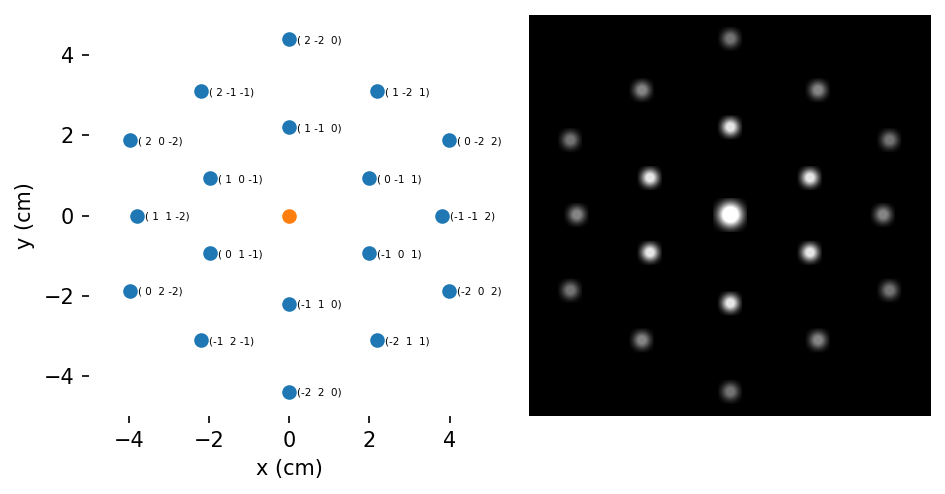

In [7]:
# Render logic
nax = 1
if render_style == 'both':
    nax = 2
fig, ax = plt.subplots(1,nax, dpi=150)

# Helpful rendering
if render_style == 'helpful':
    helpful_render(ax, df)
elif render_style == 'pretty':
    pretty_render(ax, df)
elif render_style == 'both':
    helpful_render(ax[0], df)
    pretty_render(ax[1], df)

fig.tight_layout()

In [8]:
df

,plane,d (Å),R (cm),Angle (deg),x (cm),y (cm)
0,"[0, 1, -1]",2.234457,2.195479,-154.760598,-1.985885e+00,-9.361553e-01
1,"[-1, 1, 0]",2.234457,2.195479,-90.000000,1.344343e-16,-2.195479e+00
2,"[-1, 0, 1]",2.234457,2.195479,-25.239402,1.985885e+00,-9.361553e-01
3,"[0, -1, 1]",2.234457,2.195479,25.239402,1.985885e+00,9.361553e-01
4,"[1, -1, 0]",2.234457,2.195479,90.000000,1.344343e-16,2.195479e+00
5,"[1, 0, -1]",2.234457,2.195479,154.760598,-1.985885e+00,9.361553e-01
6,"[-1, 2, -1]",1.290065,3.802681,-125.264390,-2.195479e+00,-3.104876e+00
7,"[-2, 1, 1]",1.290065,3.802681,-54.735610,2.195479e+00,-3.104876e+00
8,"[-1, -1, 2]",1.290065,3.802681,0.000000,3.802681e+00,0.000000e+00
9,"[1, -2, 1]",1.290065,3.802681,54.735610,2.195479e+00,3.104876e+00


In [9]:
# Additional code for calculating camera length
# From calculations
# d = np.array([1.27,0.735,0.636])*1e-10
d = np.array([2.08,1.8,1.27])*1e-10
# Measured
# R_vec = np.array([1.58,2.73,3.17])*1e-2
R_vec = np.array([1.5,1.7,2.45])*1e-2
# Given and equated
w = h/np.sqrt(2*m_e*e*200000)
L_vec = d/w*R_vec
# Final results
print(L_vec)
print(f"{L_vec.mean():.3f} m is the mean camera length")

[1.1377013  1.11582243 1.13460179]
1.129 m is the mean camera length
